# Detección de Videos generados por medio de DeepFake

## Extracción de características

Importación de las librerías necesarias.

In [3]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import json
import time
import pickle
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import random
from IPython.display import Video

import torch
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

%matplotlib inline

Carga del archivo creado luego de balancear los datos.

In [4]:
data_def = pd.read_csv('data_definitiva.csv', sep = '|')
data_def = data_def.drop('Unnamed: 0', axis = 1)
data_def = data_def.values.tolist()

Clases del conjunto de datos.

In [5]:
classes = list(set([x[1] for x in data_def]))
print(classes)

['REAL', 'FAKE']


Definición de la cantidad de frames a tomar del video y el tamaño final de las imágenes.

In [6]:
n_videos = len(data_def)
n_frames = 30
final_shape = (100, 100)

Creación de los arrays donde se va a incluir la información.

In [7]:
images = np.empty(shape = (n_videos, n_frames, final_shape[0], final_shape[1], 3), dtype=int)
labels = np.empty(shape = (n_videos), dtype = int)

Validación del dispositivo donde va a ser ejecutado Torch.

In [8]:
torch_home = get_torch_home()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


Creación del objeto Multi-task Cascaded Convolutional Networks para la detección de rostros en los frames del video.

In [9]:
mtcnn = MTCNN(image_size =final_shape[0] ,margin=14, factor=0.5, post_process = False).eval()

Función para convertir los datos y dar el orden necesario a los canales RGB de las imágenes de los rostros extraídos a partir de los frames de los videos.

In [11]:
def process_image(images):
    n_images = len(images)
    f_shape = images[0].shape
    images_p = np.empty(shape = (n_images, f_shape[-2], f_shape[-1], f_shape[-3]), dtype = int)
    for i in range(n_images):
        images_p[i, :, :, :] = images[i][:,:,:].permute(1,2,0).int().numpy()
    return images_p    

Clase utilizada para la extracción de rostros en las imagenes extraídas del video. Debido a que en algunos frames no se detectaban rostros y que obtener los rostros para los 300 frames del video era muy pesado computacionalmente, se utilizó un espaciamiento lineal entre 0 y la cantidad de frames del video para obtener muestras representativas de la temporalidad del video, y si no se podían extraer los rostros de todos los frames espaciados linealmente, se eliminaban los frames en los cuales no se detectaban rostros y se tomaban otros indices y se agregaban los nuevos rostros extraídos a partir de los frames al dataset definitivo. Este procedimiento se repite hasta obtener la cantidad de frames pasados por parámetros.

In [17]:
class DetectionPipeline:

    def __init__(self, detector, n_frames=50):

        self.detector = detector
        self.n_frames = n_frames
        
    def __call__(self, filename):
 
   
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        faces = []
        frames = []
        def_faces = []
        for j in range(v_len):
            success = v_cap.grab()
            success, frame = v_cap.retrieve()
            if not success:
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frames.append(frame)
        
        idxs = [x for x in range(len(frames))]
        cond = True
        while cond:
            
            if len(idxs)>n_frames:
                slice_idxs =  random.sample(idxs, n_frames-len(def_faces))
                slice_idxs.sort()
                idxs = [x for x in idxs if x not in slice_idxs]
                sample = [frames[x] for x in slice_idxs]
                faces = self.detector(sample)
                temp_faces = [f for f in faces if f != None]
                def_faces.extend(temp_faces)
            else:
                def_faces.extend(frames)

            if len(def_faces)>=n_frames:
                cond = False
                def_faces = def_faces[:30]
        
        def_faces = process_image(def_faces)
        v_cap.release()
        
        return frames, def_faces

Declaración del objeto usado para extraer los rostros.

In [18]:
detection_pipeline = DetectionPipeline(detector=mtcnn, n_frames = n_frames)

Para agilizar el procedimiento (debido a que la extracción de rostros de los frames del video toma bastante tiempo, aproximadamente 20 s por video 20s*2400 videos = 13.3 horas) se dividió la extracción en 3 scripts diferentes para reducir este tiempo a 4.5 horas.

In [21]:
filename = 'D:/ProyectoMLT/' + data_def[n][0]
print(filename)

D:/ProyectoMLT/dataset/batch-02/tgawasvbbr.mp4


In [13]:
n_parts = 3
part = 1
intervals = np.linspace(0, n_videos, n_parts+1, dtype = int)

start, end = intervals[part-1], intervals[part]

for idx in tqdm(range(start, end)):
    video_path = data_def[idx][0]
    label = data_def[idx][1]
    images[idx, :, :, :, :] = detection_pipeline(video_path)
    labels[idx] = 0 if label == 'REAL' else 1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
C:\Users\DanielBaron\anaconda3\envs\g

Para evitar el reprocesamiento de las imágenes, las variables images y labels se exportaron a archivos con extensión pckl, con el fin de ser cargados en la etapa de entrenamiento y validación.

In [16]:
#Save the variables that contain the loaded images and their labels
f = open('images_part_{}.pckl'.format(part), 'wb')
pickle.dump(images[start:end,:,:,:,:], f)
f.close()

f = open('labels_{}.pckl'.format(part), 'wb')
pickle.dump(labels[start:end], f)
f.close()

In [18]:
n = 250
video_path = data_def[n][0]

Video(video_path, height=400)

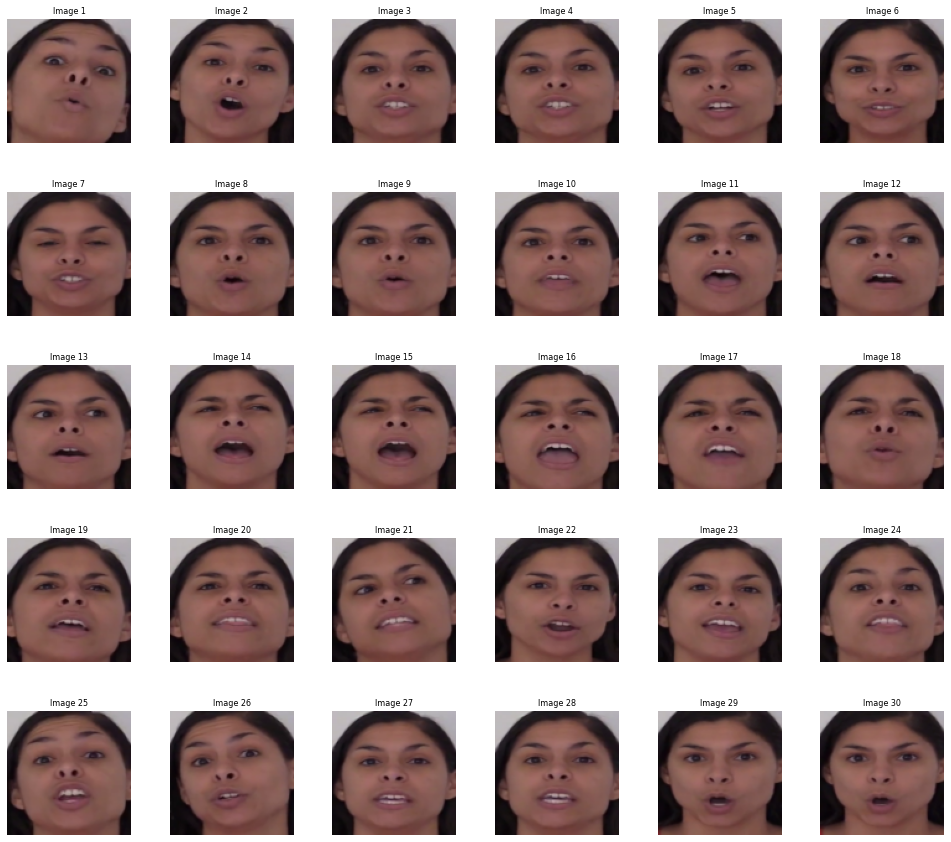

In [16]:
W_grid = 6
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,15))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    axes[i].imshow(images[n,i,:,:,:], cmap ='gray')
    axes[i].set_title('Image {}'.format(i+1), fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)